# RSNA Data Wrangling and EDA

### Import Required Packages

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pydicom
from pydicom.data import get_testdata_files
import plotly.express as px
from pprint import pprint
import nibabel as nib
from ipywidgets import interact

In [115]:
main_folder = "/kaggle/input/rsna-2023-abdominal-trauma-detection/"
!ls {main_folder}

image_level_labels.csv	 test_images		   train_images
sample_submission.csv	 test_series_meta.csv	   train_series_meta.csv
segmentations		 train.csv
test_dicom_tags.parquet  train_dicom_tags.parquet


### Load Raw Training Data

In [116]:
train = pd.read_csv(main_folder + "train.csv")
train.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [117]:
#Inspect training data properties
print(train.info(),'\n')
print('*'*40, '\n')
print("Null Values:\n",train.isnull().sum(), '\n')
print('*'*40,'\n')
print("Number of Unique Values:\n",train.nunique(),'\n')
print('*'*40,'\n')
print("Duplicate Values:\n",train.duplicated().sum(),'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   patient_id             3147 non-null   int64
 1   bowel_healthy          3147 non-null   int64
 2   bowel_injury           3147 non-null   int64
 3   extravasation_healthy  3147 non-null   int64
 4   extravasation_injury   3147 non-null   int64
 5   kidney_healthy         3147 non-null   int64
 6   kidney_low             3147 non-null   int64
 7   kidney_high            3147 non-null   int64
 8   liver_healthy          3147 non-null   int64
 9   liver_low              3147 non-null   int64
 10  liver_high             3147 non-null   int64
 11  spleen_healthy         3147 non-null   int64
 12  spleen_low             3147 non-null   int64
 13  spleen_high            3147 non-null   int64
 14  any_injury             3147 non-null   int64
dtypes: int64(15)
memory usage: 368.9 KB
No

* There are total 3147 rows and 15 columns
* Training data is well structed and appears to be one-hot encoded
* There are no null or missing values.

### Load Raw Training Meta Data

In [118]:
train_series_meta = pd.read_csv(main_folder + "train_series_meta.csv")
train_series_meta.head()

,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0


In [119]:
print(train_series_meta.info(), '\n')
print('*'*40, '\n')
print("Null Values:\n",train_series_meta.isnull().sum(), '\n')
print('*'*40, '\n')
print("Number of Unique Values:\n",train_series_meta.nunique(), '\n')
print('*'*40, '\n')
print("Duplicate Values:\n",train_series_meta.duplicated().sum(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4711 entries, 0 to 4710
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient_id        4711 non-null   int64  
 1   series_id         4711 non-null   int64  
 2   aortic_hu         4711 non-null   float64
 3   incomplete_organ  4711 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 147.3 KB
None 

**************************************** 

Null Values:
 patient_id          0
series_id           0
aortic_hu           0
incomplete_organ    0
dtype: int64 

**************************************** 

Number of Unique Values:
 patient_id          3147
series_id           4711
aortic_hu            717
incomplete_organ       2
dtype: int64 

**************************************** 

Duplicate Values:
 0 



* There are total 4711 rows and 4 columns
* Appears to have repetiting patient IDs, possibility of patients having multiple scans

## Feature Engineering

### Removing one-hot encoding for exploratory data analysis

In [120]:
#Creating a copy of the training data set
train_con = train.copy(deep=True)

In [121]:
train_con['bowel'] = (train_con.iloc[:, 1:3] == 1).idxmax(1)
train_con['extravasation'] = (train_con.iloc[:, 3:5] == 1).idxmax(1)
train_con['kidney'] = (train_con.iloc[:, 5:8] == 1).idxmax(1)
train_con['liver'] = (train_con.iloc[:, 8:11] == 1).idxmax(1)
train_con['spleen'] = (train_con.iloc[:, 11:14] == 1).idxmax(1)

train_con.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,bowel,extravasation,kidney,liver,spleen
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,bowel_healthy,extravasation_injury,kidney_low,liver_healthy,spleen_high
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_low


In [122]:
train_con = train_con.drop(columns =['bowel_healthy','bowel_injury','extravasation_healthy','extravasation_injury','kidney_healthy','kidney_low','kidney_high','liver_healthy','liver_low','liver_high',
                             'spleen_healthy','spleen_low','spleen_high'])
train_con.head()

,patient_id,any_injury,bowel,extravasation,kidney,liver,spleen
0,10004,1,bowel_healthy,extravasation_injury,kidney_low,liver_healthy,spleen_high
1,10005,0,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy
2,10007,0,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy
3,10026,0,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy
4,10051,1,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_low


## Load "image_level_labels.csv" file

In [123]:
image_labels = pd.read_csv(main_folder + "image_level_labels.csv")
image_labels.head()

,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation


In [124]:
print(image_labels.info(), '\n')
print('*'*40, '\n')
print("Number of Unique Values:\n",image_labels.nunique(), '\n')
print('*'*40, '\n')
print("Duplicate Values:\n",image_labels.duplicated().sum(), '\n')
print('*'*40, '\n')
print("Null Values:\n",image_labels.isnull().sum(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12029 entries, 0 to 12028
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_id       12029 non-null  int64 
 1   series_id        12029 non-null  int64 
 2   instance_number  12029 non-null  int64 
 3   injury_name      12029 non-null  object
dtypes: int64(3), object(1)
memory usage: 376.0+ KB
None 

**************************************** 

Number of Unique Values:
 patient_id         246
series_id          330
instance_number    925
injury_name          2
dtype: int64 

**************************************** 

Duplicate Values:
 0 

**************************************** 

Null Values:
 patient_id         0
series_id          0
instance_number    0
injury_name        0
dtype: int64 



* There are a total of 12029 rows and 4 columns
* All columns have repeating values indicating multiple patient entries 
* There are no null or missing values

## Load "train_dicom_tags.parquet" file

In [125]:
train_dicom_tags = pd.read_parquet(main_folder + "train_dicom_tags.parquet")
train_dicom_tags.head()

,BitsAllocated,BitsStored,Columns,ContentDate,ContentTime,FrameOfReferenceUID,HighBit,ImageOrientationPatient,ImagePositionPatient,InstanceNumber,...,WindowCenter,WindowWidth,FileMetaInformationVersion,ImplementationClassUID,ImplementationVersionName,MediaStorageSOPClassUID,MediaStorageSOPInstanceUID,TransferSyntaxUID,path,RescaleType
0,16,16,512,20230722,003306.881589,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1459.20]",532,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.532,1.2.840.10008.1.2.5,train_images/49954/41479/532.dcm,nan
1,16,16,512,20230722,003303.279137,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1474.40]",513,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.513,1.2.840.10008.1.2.5,train_images/49954/41479/513.dcm,nan
2,16,16,512,20230722,003343.090736,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1310.40]",718,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.718,1.2.840.10008.1.2.5,train_images/49954/41479/718.dcm,nan
3,16,16,512,20230722,003252.960345,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1520.00]",456,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.456,1.2.840.10008.1.2.5,train_images/49954/41479/456.dcm,nan
4,16,16,512,20230722,003155.059398,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1756.00]",161,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.161,1.2.840.10008.1.2.5,train_images/49954/41479/161.dcm,nan


In [126]:
print(train_dicom_tags.info(), '\n')
print('*'*40, '\n')
print("Null Values:\n",train_dicom_tags.isnull().sum(), '\n')
print('*'*40, '\n')
print("Number of Unique Values:\n",train_dicom_tags.nunique(), '\n')
print('*'*40, '\n')
print("Duplicate Values:\n",train_dicom_tags.duplicated().sum(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510373 entries, 0 to 1510372
Data columns (total 35 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   BitsAllocated               1510373 non-null  int64  
 1   BitsStored                  1510373 non-null  int64  
 2   Columns                     1510373 non-null  int64  
 3   ContentDate                 1510373 non-null  object 
 4   ContentTime                 1510373 non-null  object 
 5   FrameOfReferenceUID         1510373 non-null  object 
 6   HighBit                     1510373 non-null  int64  
 7   ImageOrientationPatient     1510373 non-null  object 
 8   ImagePositionPatient        1510373 non-null  object 
 9   InstanceNumber              1510373 non-null  int64  
 10  KVP                         1510373 non-null  float64
 11  PatientID                   1510373 non-null  object 
 12  PatientPosition             1510373 non-null  object 
 1

* There are a total of 1,510,373 rows and 35 columns
* All columns execpt for path have repeating values indicating multiple patient entries and commonality in scans
* There are no null or missing values

## Visualization 

### Injuries Reported

In [127]:
fig = px.pie(train_con, names=train['any_injury'].map({1: 'Patient Injured', 0: 'No Injury'}), height=500, width= 500, color_discrete_sequence=['#D3D3D3','black'], title='Injuries Reported in Patients')
fig.update_traces(textfont_size=15)
fig.show()

### Bowel, Extravasation Organ Health in Patient

In [128]:
for column in train_con.columns[2:4]:
    fig = px.pie(train_con, names=train_con[column], height=450, width= 450, color_discrete_sequence=['#D3D3D3','black'], 
             title=f' Pie-Chart of {column}')
    fig.update_traces(textfont_size=15)
    fig.show()

### Kidney, Liver, Spleen Organ Health in Patients

In [129]:
for column in train_con.columns[4:]:
    fig = px.pie(train_con, names=train_con[column], height=500, width= 500, color_discrete_sequence=['#D3D3D3','black','#71797E'], 
             title=f' Pie-Chart of {column}')
    fig.update_traces(textfont_size=15)
    fig.show()

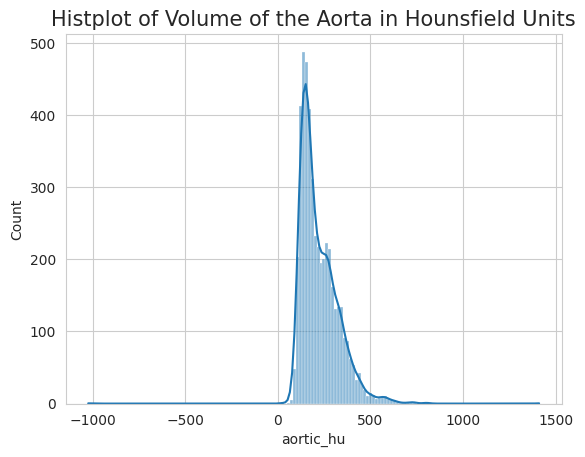

In [130]:
sns.histplot(train_series_meta['aortic_hu'],kde=True)
plt.title('Histplot of Volume of the Aorta in Hounsfield Units',fontsize=15)
plt.show()

* Indicated value below zero

In [131]:
#Verify negative value
train_series_meta[train_series_meta['aortic_hu']<0]

,patient_id,series_id,aortic_hu,incomplete_organ
1742,31284,58351,-1024.0,1


In [132]:
#Replacing patient data where aortic_hu is less than zero with mean value
train_series_meta.loc[train_series_meta.aortic_hu < 0, 'aortic_hu'] = train_series_meta['aortic_hu'].mean(axis=0)

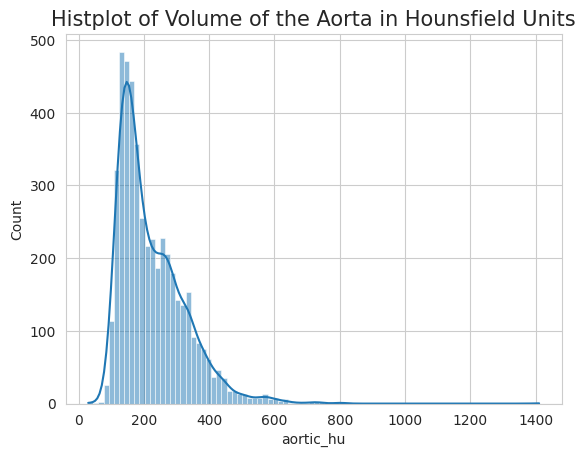

In [133]:
sns.histplot(train_series_meta['aortic_hu'],kde=True)
plt.title('Histplot of Volume of the Aorta in Hounsfield Units',fontsize=15)
plt.show()

### Verifing Scaned Properties

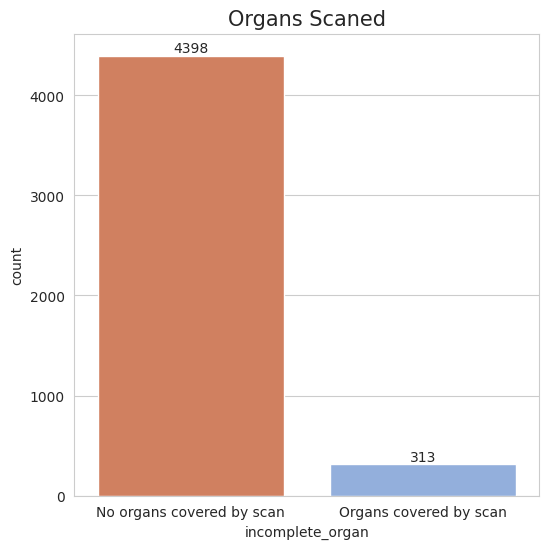

In [134]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(6,6))
ax = sns.countplot(x=train_series_meta['incomplete_organ'].map({1: 'Organs covered by scan', 0: 'No organs covered by scan'}),data=train_series_meta, palette=['#e3784d','#87ace8'])
for container in ax.containers:
    ax.bar_label(container)
plt.title('Organs Scaned',fontsize=15)
plt.show()

fig = px.pie(train_series_meta, names=train_series_meta['incomplete_organ'].map({1: 'Organs covered by scan', 0: 'No organs covered by scan'}), height=550, width= 550,
             color_discrete_sequence=['#D3D3D3','black'], title='Organs Scaned')
fig.update_traces(textfont_size=15)
fig.show()

### Injuries shown in patients image labels

In [135]:
image_labels['injury_name'].unique()

array(['Active_Extravasation', 'Bowel'], dtype=object)

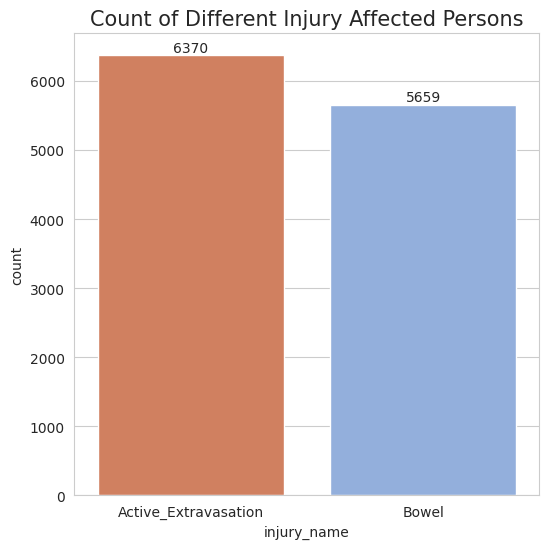

In [136]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(6,6))
ax = sns.countplot(x='injury_name',data=image_labels, palette=['#e3784d','#87ace8'])
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count of Different Injury Affected Persons',fontsize=15)
plt.show()

* No significant difference between the patients affected by both injuries

### Slice thickness distributions used for CT-Scans

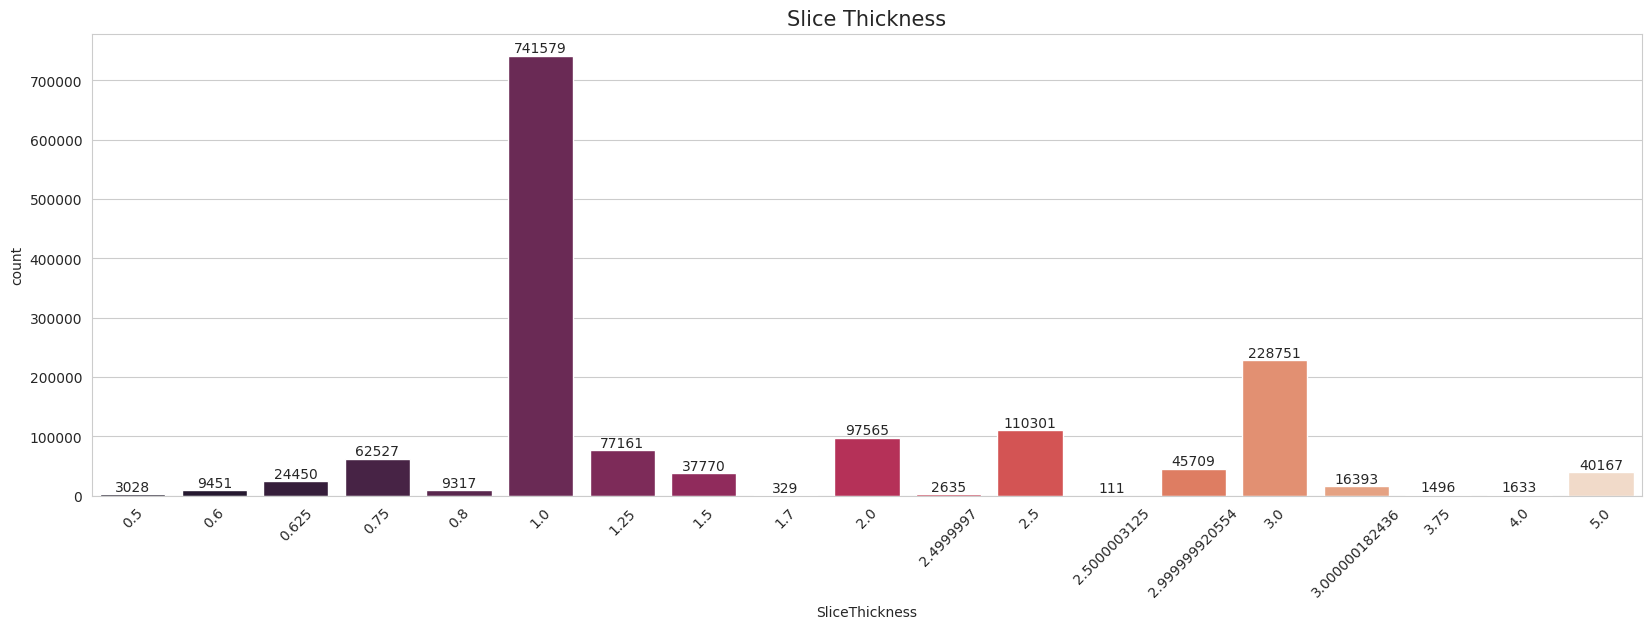

In [137]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(20,6))
ax = sns.countplot(x='SliceThickness',palette='rocket', data=train_dicom_tags)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Slice Thickness',fontsize=15)
plt.xticks(rotation=45)
plt.show()

## Reading ".dcm" files

In [138]:
sample_image = "/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/35794/42578/140.dcm"

In [139]:
def get_observation_data(path):
    '''
    Get information from the .dcm files
    '''
    dataset = pydicom.read_file(path)
    
    # Dictionary to store the information from the image
    observation_data = {
        "Rows" : dataset.get("Rows"),
        "Columns" : dataset.get("Columns"),
        "SOPInstanceUID" : dataset.get("SOPInstanceUID"),
        "ContentDate" : dataset.get("ContentDate"),
        "SliceThickness" : dataset.get("SliceThickness"),
        "InstanceNumber" : dataset.get("InstanceNumber"),
        "ImagePositionPatient" : dataset.get("ImagePositionPatient"),
        "ImageOrientationPatient" : dataset.get("ImageOrientationPatient"),
    }

    # String columns
    str_columns = ["SOPInstanceUID", "ContentDate", 
                   "SliceThickness", "InstanceNumber"]
    for k in str_columns:
        observation_data[k] = str(dataset.get(k)) if k in dataset else None

    
    return observation_data

### Getting more info about the sample dcm image

In [140]:
example = get_observation_data(sample_image)
pprint(example)

{'Columns': 512,
 'ContentDate': '20230722',
 'ImageOrientationPatient': [1, 0, 0, 0, 1, 0],
 'ImagePositionPatient': [-248.537109375, -412.537109375, 962.2],
 'InstanceNumber': '140',
 'Rows': 512,
 'SOPInstanceUID': '1.2.123.12345.1.2.3.35794.1.140',
 'SliceThickness': '3'}


### Previewing image

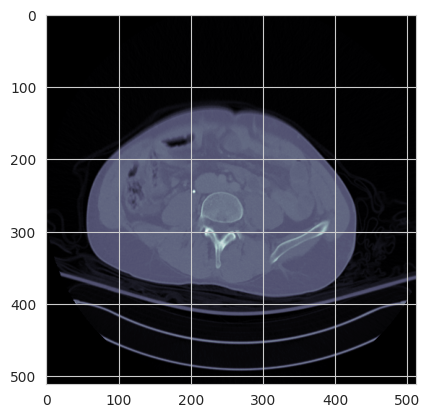

In [141]:
def plot_image(Image_path):
    ds = pydicom.dcmread(Image_path)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    plt.show()
    
plot_image(sample_image)

## Segmentations

In [142]:
sample_filename = "/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations/10252.nii"

sample_img = nib.load(sample_filename)
array = sample_img.get_fdata()
print("img shape ->", array.shape)

img shape -> (512, 512, 88)


In [143]:
print(sample_img)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 88)
affine:
[[  -0.75976598    0.            0.          189.65188599]
 [   0.            0.75976598    0.         -193.36053467]
 [   0.            0.            3.         -488.5       ]
 [   0.            0.            0.            1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512  88   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.        0.759766  0.759766  3.        0.        0.        0.
  0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min      

### Calculateing the middle slice, and previewing along the Z-axis

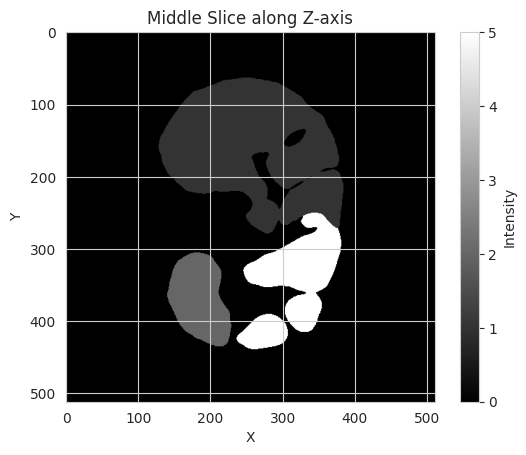

In [144]:
middle_slice = array[:,:,array.shape[2] // 2]

plt.imshow(middle_slice, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Middle Slice along Z-axis')
plt.colorbar(label='Intensity')
plt.show()

### Visualizing Images as a slider

In [145]:
def show_slice(i):
    plt.imshow(array[:,:,i], cmap='gray')
    plt.show()

interact(show_slice, i=(0, array.shape[2]-1))

interactive(children=(IntSlider(value=43, description='i', max=87), Output()), _dom_classes=('widget-interact'…

<function __main__.show_slice(i)>